In [1]:
import matplotlib.pyplot as plt
import pandas as pd # and of course Pandas
import numpy as np
import ipywidgets as widgets
from matplotlib.patches import Rectangle
#from scipy.signal import freqz
from scipy.signal import butter, lfilter    #module for bandpass filter the signal

### Read Data files

In [2]:
#read file with orbital solutions
# taken from: http://vo.imcce.fr/insola/earth/online/earth/online/index.php
#A&A 428, 261-285 (2004), DOI: 10.1051/0004-6361:20041335
#Laskar, J., Robutel, P., Joutel, F., Gastineau, M., Correia, A.C.M., Levrard, B. : 2004,
#A long term numerical solution for the insolation quantities of the Earth.

laskar2004 = pd.read_csv('laskar2004-100Ma_65N_july_insol', delimiter= '\s+', header=None)
laskar2004.columns = ["Age(Myr)", "eccentricity", 'precession', "obliquity", "65N july insola"]
laskar2004["Age(Myr)"] = -0.001*laskar2004["Age(Myr)"]

age = laskar2004['Age(Myr)']
eccentricity = laskar2004['eccentricity']
obliquity = laskar2004['obliquity']
precession = laskar2004['precession']
insolation = laskar2004['65N july insola']
laskar2004.head()

,Age(Myr),eccentricity,precession,obliquity,65N july insola
0,100.000,0.025067,0.025026,0.407037,458.862548
1,99.999,0.025403,0.023597,0.407379,457.461756
2,99.998,0.025716,0.019669,0.407615,457.555120
3,99.997,0.026040,0.013689,0.407742,459.007579
4,99.996,0.026288,0.006020,0.407753,461.823106


In [3]:
#read isotope data from Westerhold2020
file = 'westerhold2020_isotopes.xlsx'
xls = pd.ExcelFile(file)
isotopes = xls.parse(0) #first sheet (0) of the excel file parsed to variable
isotopes

,age(Ma),d13C,d18O
0,0.000,-0.800000,3.520000
1,0.002,0.430000,3.570000
2,0.004,-0.645000,3.535000
3,0.006,0.046667,3.806667
4,0.008,-0.313333,3.960000
...,...,...,...
23624,67.080,1.403500,0.825000
23625,67.085,1.333500,0.825000
23626,67.090,1.199500,0.785000
23627,67.095,1.282333,0.796667


In [4]:
#read sea level data from Miller etal 2020
file = 'Miller_2020_sealevel.xlsx'
xls = pd.ExcelFile(file)
sealevel = xls.parse(0) #first sheet (0) of the excel file parsed to variable
sealevel_smooth = xls.parse(1) #first sheet (0) of the excel file parsed to variable
sealevel_smooth.head()

,Age(Ma),SeaLevel_smooth(m)
0,0.98,-33.0
1,1.00,-32.2
2,1.02,-31.5
3,1.04,-30.8
4,1.06,-30.1


In [5]:
#read file with age of geomagnetic chrons
file = "gpts1995-2020.xlsx"
xls = pd.ExcelFile(file)
datafile = xls.parse(0) #first sheet (0) of the excel file parsed to variable
datafile.fillna('')

,Magnetochron-base,epoch,CK1995,GTS2004,GTS2012,GTS2016,GTS2020,wes2020,Sources of calibration used in GTS2020
0,,,0.0,0.0,0.0,0.0,0.000,0.0,
1,C1n,(Brunhes),0.78,0.781,0.781,0.773,0.773,0.781,no change from GTS2016
2,C1r.1r,(Matuyama),0.99,0.988,0.988,1.008,1.008,0.988,
3,C1r.1n,(Jaramillo),1.07,1.072,1.072,1.076,1.076,1.072,
4,C1r.2r,,,1.173,1.173,1.189,1.189,1.173,
...,...,...,...,...,...,...,...,...,...
184,C32r.1r,,,,,,73.951,,
185,C32r.1n,,,,,,74.051,,
186,C32r.2r,,,,,,74.201,,
187,C33n,,,,,,79.900,,


In [6]:
#read file with age of stages and epochs
file = "gpts1995-2020.xlsx"
xls = pd.ExcelFile(file)
chronostrat = xls.parse(1) #first sheet (0) of the excel file parsed to variable
chronostrat.fillna('')

,Period,Age,Stage,GTS2020 (Ma)
0,-,-,-,0.000
1,,Holocene,,0.118
2,,,Tarantian,0.130
3,,,Chibanian,0.773
4,,,Calabrian,1.800
5,Quaternary,Pleistocene,Gelasian,2.580
6,,,Piacenzian,3.600
7,,Pliocene,Zanclean,5.340
8,,,Messinian,7.246
9,,,Tortonian,11.630


In [7]:
chrono_age = chronostrat.dropna(subset=['Age'])
chrono_age = chrono_age.reset_index(drop = True)
chrono_age[['Age','GTS2020 (Ma)']]

,Age,GTS2020 (Ma)
0,-,0.000
1,Holocene,0.118
2,Pleistocene,2.580
3,Pliocene,5.340
4,Miocene,23.040
5,Oligocene,33.900
6,Eocene,56.000
7,Paleocene,66.040


### Filter of Orbital Solutions

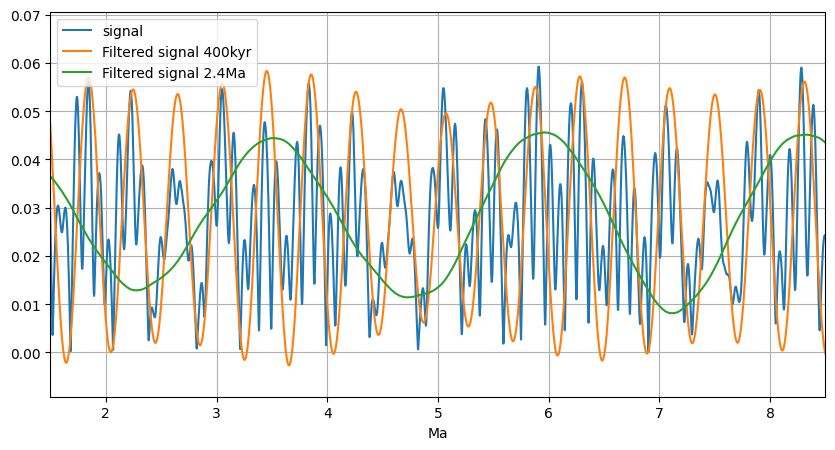

In [8]:
#Orbital solutions
age = laskar2004['Age(Myr)']
eccentricity = laskar2004['eccentricity']
obliquity = laskar2004['obliquity']
precession = laskar2004['precession']
insolation = laskar2004['65N july insola']

#Filter astronomical solutions
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in cycles/unit_time).
fs = 1000              #number of time_steps/unit_time(Ma)
lowcut = 1/0.450       #cycles/unit_time(Ma)
highcut = 1/0.350      #cycles/unit_time(Ma)
longecc_lowcut = 1/3
longecc_highcut = 1/2
# Filter a noisy signal.
#T = 100 #0.05  total duration of Time
#nsamples = T * fs # number of samples: Time * sample rate
#    t = np.arange(0, nsamples) / fs
#time = age
signal = eccentricity
plt.figure(figsize = (10,5))
plt.clf()
plt.plot(age, signal, label='signal')

# plot 400kyr eccentricity filter 
filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order=3)
filtered_signal_weighted = filtered_signal*(np.max(signal)-np.min(signal))/ \
                        (np.max(filtered_signal)-np.min(filtered_signal))+np.mean(signal)
plt.plot(age, filtered_signal_weighted, label='Filtered signal 400kyr')

# plot long eccentricity 
longecc_filtered_signal = butter_bandpass_filter(signal, longecc_lowcut, longecc_highcut, fs, order=2)
longecc_filtered_signal_weighted = longecc_filtered_signal*(np.max(signal)-np.min(signal))/ \
                        (np.max(longecc_filtered_signal)-np.min(longecc_filtered_signal))+np.mean(signal)
plt.plot(age, longecc_filtered_signal_weighted, label='Filtered signal 2.4Ma')

plt.xlabel('Ma')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.xlim(left = 1.5, right = 8.5)

plt.show()

In [9]:
fig_height = str(input('Set the height of figure (default = 20): '))
if not fig_height:
    fig_height = 20
fig_height = float(fig_height)

Set the height of figure (default = 20): 10


In [10]:
AgeMin = widgets.BoundedFloatText(
    value=0,
    min=0,
    max=66.04,
    step=0.1,
    description='Age Min:',
    disabled=False
)
AgeMax = widgets.BoundedFloatText(
    value=10,
    min=0,
    max=66.04,
    step=0.1,
    description='Age Max:',
    disabled=False
)
widgetLink = widgets.jslink((AgeMax, 'min'),(AgeMin,'value'))
widgetLink = widgets.jslink((AgeMin, 'max'),(AgeMax,'value'))

gpts_models = ['CK1995','GTS2004','GTS2012','GTS2016','GTS2020','wes2020']
GPTS = widgets.Select(options = gpts_models,
                      description='GPTS model:',
                      value = 'wes2020'
                     )

ecc = widgets.Checkbox(
    value=False,
    description='eccentricity',
    disabled=False,
    indent=False
)
tilt = widgets.Checkbox(
    value=False,
    description='obliquity',
    disabled=False,
    indent=False
)
prec = widgets.Checkbox(
    value=False,
    description='precession',
    disabled=False,
    indent=False
)
insol = widgets.Checkbox(
    value=False,
    description='insolation',
    disabled=False,
    indent=False
)
SeaLevel = widgets.Checkbox(
    value=False,
    description='Sea Level',
    disabled=False,
    indent=False
)
dO18 = widgets.Checkbox(
    value=False,
    description='delta O18',
    disabled=False,
    indent=False
)
dC13 = widgets.Checkbox(
    value=False,
    description='delta C13',
    disabled=False,
    indent=False
)
box_age = widgets.HBox([AgeMin, AgeMax, GPTS])

box_orbital = widgets.VBox([ecc, tilt, prec, insol])
box_curves = widgets.VBox([SeaLevel, dO18,dC13])
box2 = widgets.HBox([box_orbital,box_curves])
display(box_age,box2)

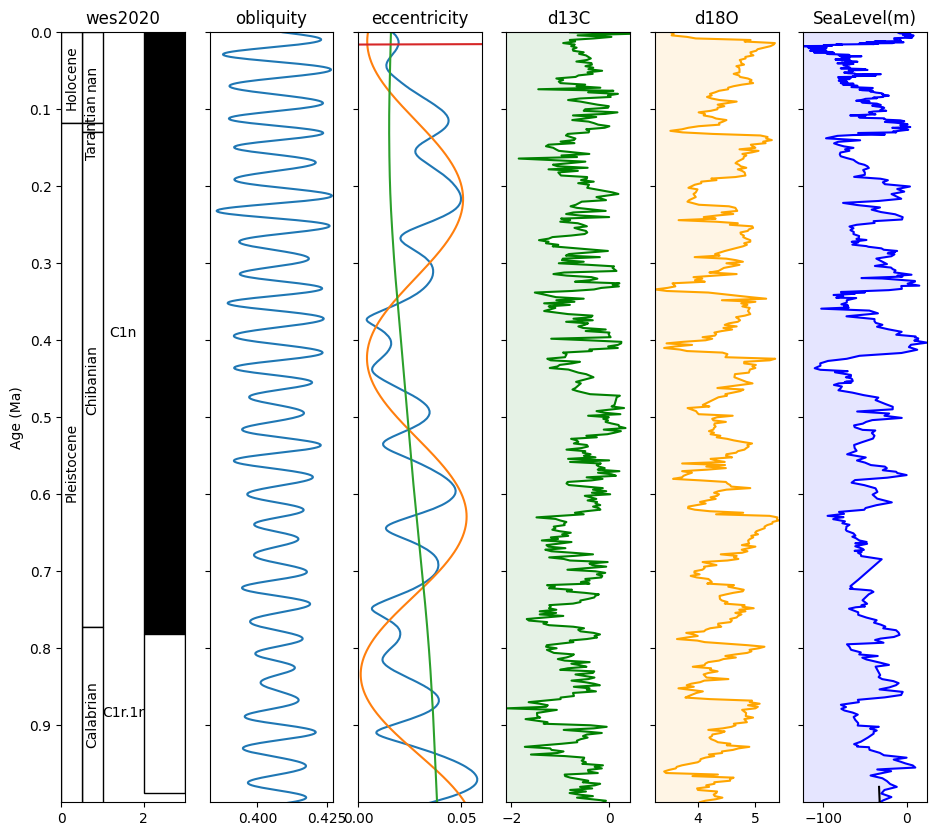

In [14]:
plot_selection = {'eccentricity': ecc.value,
              'obliquity': tilt.value,
              'precession': prec.value,
              'insolation': insol.value,
              'SeaLevel': SeaLevel.value,
              'dO18': dO18.value,
              'dC13': dC13.value}
selected_plots = []
for n in plot_selection:
    if plot_selection[n]:
        selected_plots.append(n)

#select age range to plot
minAge = AgeMin.value
maxAge = AgeMax.value

#fig_height = 20
fig = plt.figure(figsize=(15, fig_height))     #width and height

resolution = (maxAge-minAge)/fig_height
tick_interval = 2
if resolution < 2:
    tick_interval = 1
    if resolution < 1:
        tick_interval = 0.5
        if resolution < 0.5:
            tick_interval = 0.2
            if resolution < 0.2:
                tick_interval = 0.1
tick_range = np.arange(minAge, maxAge, tick_interval)

plot_number = {0:'ax2', 1:'ax3', 2:'ax4', 3:'ax5', 4:'ax6', 5:'ax7', 6:'ax8'}

ax1 = fig.add_subplot(1,8,1)

#drawing polarity column
width = 1
for value in range(len(datafile[datafile['GTS2020']<=minAge]),1+len(datafile[datafile['GTS2020']<maxAge])):
    bottom_left = (2,datafile.loc[value-1,GPTS.value])
    height = datafile.loc[value,GPTS.value]-datafile.loc[value-1,GPTS.value]
    midpoint_height = (datafile.loc[value,GPTS.value]+datafile.loc[value-1,GPTS.value])/2
    polarity = datafile.loc[value,'Magnetochron-base'][-1:]
    if polarity == 'n':
        fill = 'black'
    else:
        fill = 'white'
    ax1.add_patch(Rectangle(bottom_left, width, height, angle=0.0, facecolor =fill, edgecolor = 'black'))
    if datafile.loc[value,GPTS.value] > maxAge:
      midpoint_height = (maxAge+datafile.loc[value-1,GPTS.value])/2
    if datafile.loc[value-1,GPTS.value] < minAge:
      midpoint_height = (datafile.loc[value,GPTS.value]+minAge)/2
    ax1.text(1.5, midpoint_height, datafile.loc[value,'Magnetochron-base'], horizontalalignment='center', verticalalignment='center',
         rotation=0)
#drawing stage column
width = 0.5
for value in range(len(chronostrat[chronostrat['GTS2020 (Ma)']<=minAge]),1+len(chronostrat[chronostrat['GTS2020 (Ma)']<maxAge])):
    bottom_left = (0.5,chronostrat.loc[value-1,'GTS2020 (Ma)'])
    height = chronostrat.loc[value,'GTS2020 (Ma)']-chronostrat.loc[value-1,'GTS2020 (Ma)']
    midpoint_height = (chronostrat.loc[value,'GTS2020 (Ma)']+chronostrat.loc[value-1,'GTS2020 (Ma)'])/2
    ax1.add_patch(Rectangle(bottom_left, width, height, angle=0.0, facecolor ='white', edgecolor = 'black'))
    if chronostrat.loc[value,'GTS2020 (Ma)'] > maxAge:
      midpoint_height = (maxAge+chronostrat.loc[value-1,'GTS2020 (Ma)'])/2
    if chronostrat.loc[value-1,'GTS2020 (Ma)'] < minAge:
      midpoint_height = (chronostrat.loc[value,'GTS2020 (Ma)']+minAge)/2
    ax1.text(0.75, midpoint_height, chronostrat.loc[value,'Stage'], horizontalalignment='center', verticalalignment='center',
         rotation=90)
# drawing Age column    
width = 0.5
for value in range(len(chrono_age[chrono_age['GTS2020 (Ma)']<=minAge]),1+len(chrono_age[chrono_age['GTS2020 (Ma)']<maxAge])):
    bottom_left = (0,chrono_age.loc[value-1,'GTS2020 (Ma)'])
    height = chrono_age.loc[value,'GTS2020 (Ma)']-chrono_age.loc[value-1,'GTS2020 (Ma)']
    midpoint_height = (chrono_age.loc[value,'GTS2020 (Ma)']+chrono_age.loc[value-1,'GTS2020 (Ma)'])/2
    ax1.add_patch(Rectangle(bottom_left, width, height, angle=0.0, facecolor ='white', edgecolor = 'black'))
    if chrono_age.loc[value,'GTS2020 (Ma)'] > maxAge:
        if chrono_age.loc[value-1,'GTS2020 (Ma)'] < minAge:
           midpoint_height = (maxAge+minAge)/2
        else:
           midpoint_height = (maxAge+chrono_age.loc[value-1,'GTS2020 (Ma)'])/2
    elif chrono_age.loc[value-1,'GTS2020 (Ma)'] < minAge:
      midpoint_height = (chrono_age.loc[value,'GTS2020 (Ma)']+minAge)/2
    ax1.text(0.25, midpoint_height, chrono_age.loc[value,'Age'], horizontalalignment='center', verticalalignment='center',
         rotation=90)
#plt.xlabel("X-AXIS")
ax1.set_title(GPTS.value)
ax1.set_ylabel("Age (Ma)")
ax1.set_xlim(left = 0, right = 3)
ax1.set_ylim(bottom = minAge, top = maxAge)
ax1.set_yticks(ticks = tick_range)
#plt.yticks(np.arange(minAge, maxAge+1, 0.1),np.arange(minAge, maxAge+1, 0.1))
ax1.invert_yaxis()
    
n = 2   

if plot_selection['obliquity']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(obliquity, age)
    plot_number[n].set_title('obliquity')
    plot_number[n].set_xlim(left = obliquity.min(), right = obliquity.max())
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    n +=1

if plot_selection['eccentricity']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(eccentricity, age)
    plot_number[n].set_title('eccentricity')
    plot_number[n].set_xlim(left = 0, right = 0.06)
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    # plot 400kyr eccentricity filter 
    fs = 1000              #number of time_steps/unit_time(Ma)
    lowcut = 1/0.450       #cycles/unit_time(Ma)
    highcut = 1/0.350      #cycles/unit_time(Ma)
    filtered_signal = butter_bandpass_filter(eccentricity, lowcut, highcut, fs, order=3)
    filtered_signal_weighted = filtered_signal*(np.max(signal)-np.min(eccentricity))/ \
                            (np.max(filtered_signal)-np.min(filtered_signal))+np.mean(eccentricity)
    plot_number[n].plot(filtered_signal_weighted, age, label='Filtered signal 400kyr')

    # plot 2.4Myr eccentricity filter 
    fs = 1000              #number of time_steps/unit_time(Ma)
    lowcut = 1/2       #cycles/unit_time(Ma)
    highcut = 1/3      #cycles/unit_time(Ma)
    longecc_filtered_signal = butter_bandpass_filter(eccentricity, longecc_lowcut, longecc_highcut, fs, order=2)
    longecc_filtered_signal_weighted = longecc_filtered_signal*(np.max(eccentricity)-np.min(eccentricity))/ \
                            (np.max(longecc_filtered_signal)-np.min(longecc_filtered_signal))+np.mean(eccentricity)
    plot_number[n].plot(longecc_filtered_signal_weighted, age, label='Filtered signal 2.4Ma')

    # plot long eccentricity 
    longecc_filtered_signal = butter_bandpass_filter(signal, longecc_lowcut, longecc_highcut, fs, order=2)
    longecc_filtered_signal_weighted = longecc_filtered_signal*(np.max(signal)-np.min(signal))/ \
                            (np.max(longecc_filtered_signal)-np.min(longecc_filtered_signal))+np.mean(signal)
    plot_number[n].plot(age, longecc_filtered_signal_weighted, label='Filtered signal 2.4Ma')
    n +=1

if plot_selection['precession']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(precession, age)
    plot_number[n].set_title('precession')
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    n +=1

if plot_selection['insolation']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(insolation, age)
    plot_number[n].set_title('insolation')
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    n +=1
    
if plot_selection['dC13']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(isotopes['d13C'],isotopes['age(Ma)'], color = 'green')
    plot_number[n].fill_betweenx(isotopes['age(Ma)'],isotopes['d13C'],isotopes['d13C'].min(),
                     facecolor='green', alpha=0.1)
    plot_number[n].set_title("d13C")
    plot_number[n].set_xlim(left = isotopes[isotopes['age(Ma)'].between(minAge,maxAge)]['d13C'].min(),
             right = isotopes[isotopes['age(Ma)'].between(minAge,maxAge)]['d13C'].max())
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    n +=1

if plot_selection['dO18']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(isotopes['d18O'],isotopes['age(Ma)'], color = 'orange')
    plot_number[n].fill_betweenx(isotopes['age(Ma)'],isotopes['d18O'],isotopes['d18O'].min(),
                     facecolor='orange', alpha=0.1)
    plot_number[n].set_title("d18O")
    plot_number[n].set_xlim(left = isotopes[isotopes['age(Ma)'].between(minAge,maxAge)]['d18O'].min(),
             right = isotopes[isotopes['age(Ma)'].between(minAge,maxAge)]['d18O'].max())
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()
    n +=1

if plot_selection['SeaLevel']:
    plot_number[n] = fig.add_subplot(1,8,n)
    plot_number[n].plot(sealevel['SeaLevel(m)'],sealevel['Age(Ma)'], color = 'blue')
    plot_number[n].plot(sealevel_smooth['SeaLevel_smooth(m)'],sealevel_smooth['Age(Ma)'], color = 'black')
    plot_number[n].fill_betweenx(sealevel['Age(Ma)'],sealevel['SeaLevel(m)'],sealevel['SeaLevel(m)'].min(),
                     facecolor='blue', alpha=0.1)

    plot_number[n].set_title("SeaLevel(m)")
    plot_number[n].set_xlim(left = sealevel[sealevel['Age(Ma)'].between(minAge,maxAge)]['SeaLevel(m)'].min(),
             right = sealevel[sealevel['Age(Ma)'].between(minAge,maxAge)]['SeaLevel(m)'].max())
    plot_number[n].set_ylim(bottom = minAge, top = maxAge)
    plot_number[n].set_yticks(ticks = tick_range)
    plot_number[n].set_yticklabels([])
    plot_number[n].invert_yaxis()

# saving plot to file
format = 'png'
plt.savefig('GTS'+str(minAge)+'-'+str(maxAge)+'Ma.'+str(format), dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=format, transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)
plt.show()